In [1]:
# walked through github tutorial found at link in week 5 readings

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
import numpy as np
import matplotlib.pyplot as plt

# make grids of points for plotting
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [3]:
p = distrib.Normal(loc=0, scale=1)
p = distrib.Bernoulli(probs=torch.tensor([0.5]))
p = distrib.Beta(concentration1=torch.tensor([0.5]), concentration0=torch.tensor([0.5]))
p = distrib.Gamma(concentration=torch.tensor([1.0]), rate=torch.tensor([1.0]))
p = distrib.Pareto(alpha=torch.tensor([1.0]), scale=torch.tensor([1.0]))

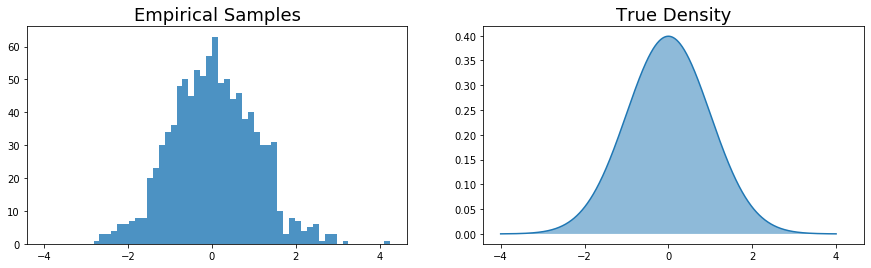

In [4]:
# normal distribution
n = distrib.Normal(0, 1)
# get samples
samples = n.sample((1000,))
# evaluate true density as samples points
density = torch.exp(n.log_prob(torch.Tensor(x))).numpy()
# plot samples and density
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15,4))
ax1.hist(samples, 50, alpha=0.8)
ax1.set_title("Empirical Samples", fontsize=18)
ax2.plot(x, density)
ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title('True Density', fontsize=18)
plt.show()

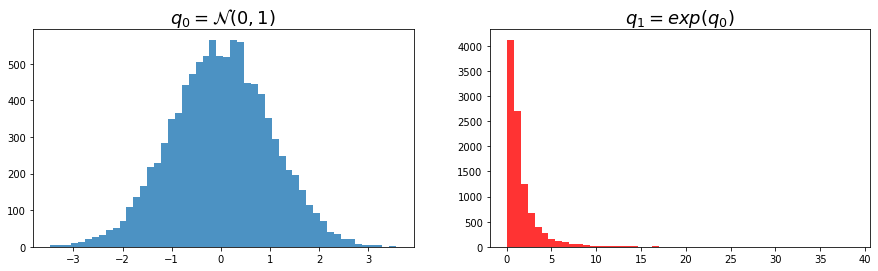

In [5]:
q0 = distrib.Normal(0, 1)
exp_t = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, exp_t)
samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(samples_q0, 50, alpha=0.8)
ax1.set_title("$q_0 = \mathcal{N}(0,1)$", fontsize=18)
ax2.hist(samples_q1, 50, alpha=0.8, color='r')
ax2.set_title("$q_1=exp(q_0)$", fontsize=18)
plt.show()

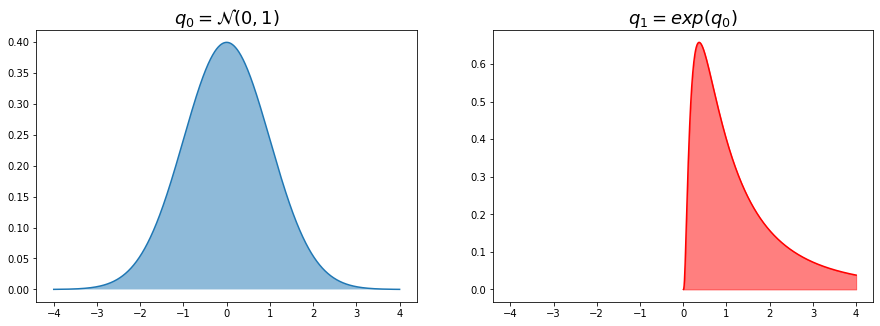

In [6]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(x))).numpy()
q1_density = torch.exp(q1.log_prob(torch.Tensor(x))).numpy()
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
ax1.plot(x, q0_density)
ax1.fill_between(x, q0_density, 0, alpha=0.5)
ax1.set_title("$q_0 = \mathcal{N}(0,1)$", fontsize=18)
ax2.plot(x, q1_density, color='r')
ax2.fill_between(x, q1_density, 0, alpha=0.5, color='r')
ax2.set_title("$q_1=exp(q_0)$", fontsize=18)
plt.show()

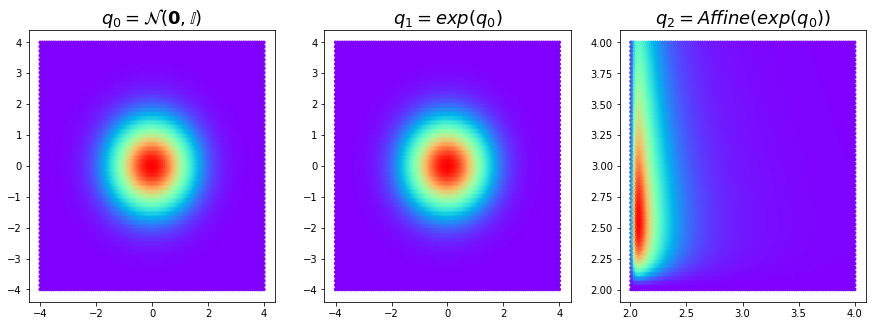

In [7]:
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
# define affine transform
f1 = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1)
# define additional transform
f2 = transform.AffineTransform(2, torch.Tensor([0.2, 1.5]))
# here we define q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, [f1, f2])
# plot 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:, 0], z[:, 1], C=torch.exp(q0.log_prob(torch.Tensor(z))),
                                        cmap='rainbow')
ax1.set_title("$q_0 = \mathcal{N}(\mathbf{0}, \mathbb{I})$", fontsize=18)
ax2.hexbin(z[:, 0], z[:, 1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax2.set_title("$q_1=exp(q_0)$", fontsize=18)
ax3.hexbin(z[:, 0], z[:, 1], C=torch.exp(q2.log_prob(torch.Tensor(z))), cmap='rainbow')
ax3.set_title("$q_2=Affine(exp(q_0))$", fontsize=18)
plt.show()

In [8]:
# f(z) = z + uh(w.T * z + b)
class PlanarFlow(transform.Transform):
    def __init__(self, weight, scale, bias):
        super(PlanarFlow, self).__init__()
        self.bijective = False
        self.weight = weight
        self.scale = scale
        self.bias = bias
        
    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)
    
    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-7)

Text(0.5, 1.0, '$q_1=planar(q_0)$')

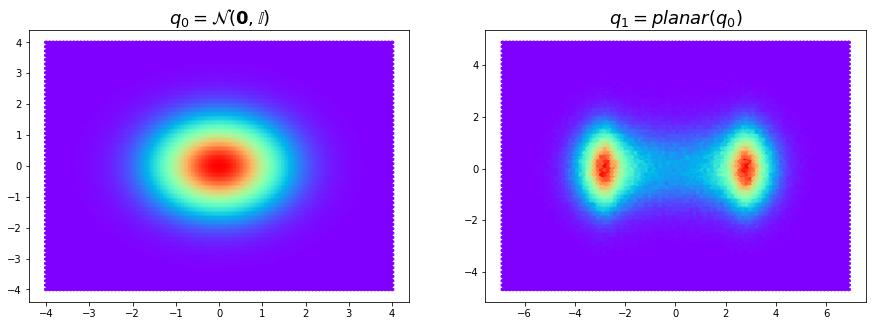

In [9]:
w = torch.Tensor([[3., 0]])
u = torch.Tensor([[2, 0]])
b = torch.Tensor([0])
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow_0 = PlanarFlow(w, u, b)
q1 = distrib.TransformedDistribution(q0, flow_0)
q1_samples = q1.sample((int(1e6), ))
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18)

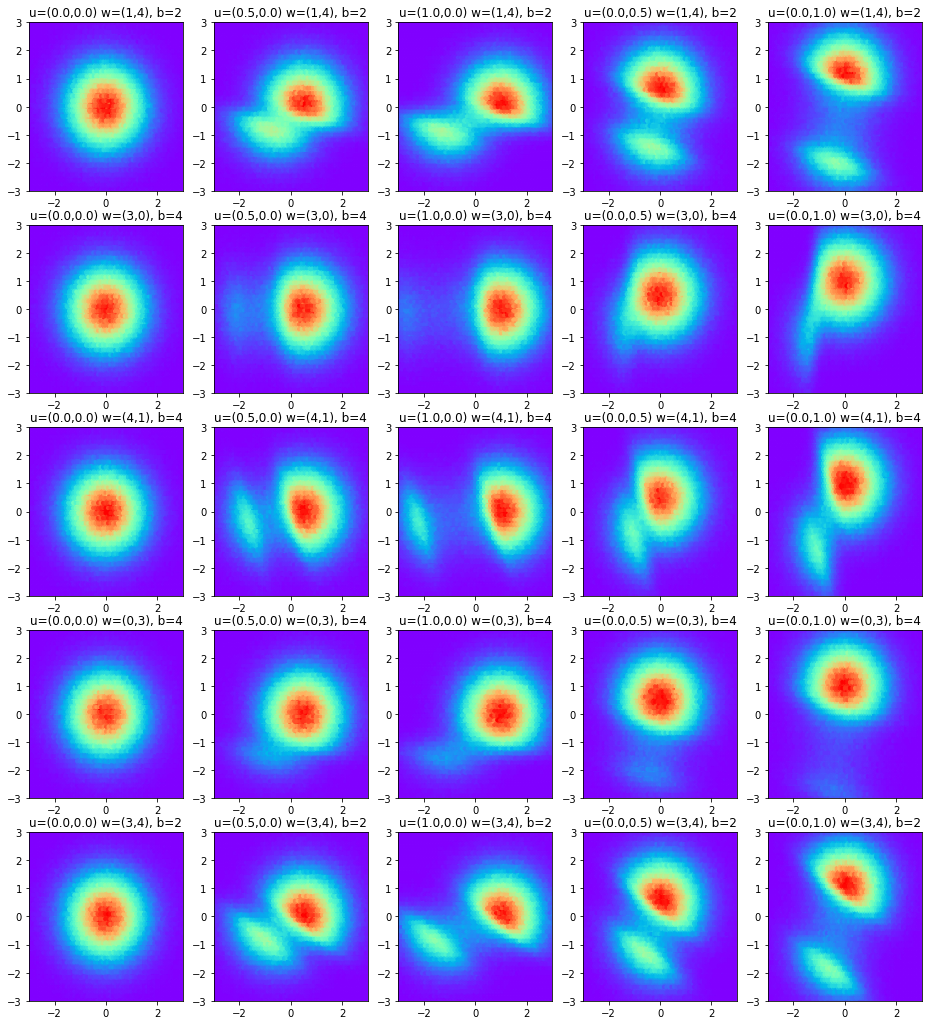

In [10]:
id_figure = 1
plt.figure(figsize=(16, 18))
for i in np.arange(5):
    # draw random hyperplane
    w = torch.rand(1, 2) * 5
    b = torch.rand(1) * 5
    for j in np.arange(5):
        # different effects of scaling factor u on the sample hyperplane (row)
        u = torch.Tensor([[((j < 3) and (j / 2.0) or 0), ((j > 2) and ((j - 2) / 2.0) or
                                                         0)]])
        
        flow_0 = PlanarFlow(w, u, b)
        q1 = distrib.TransformedDistribution(q0, flow_0)
        q1_samples = q1.sample((int(1e6), ))
        plt.subplot(5, 5, id_figure)
        plt.hexbin(q1_samples[:, 0], q1_samples[:, 1], cmap='rainbow')
        plt.title("u=(%.1f,%.1f)"%(u[0,0],u[0,1]) + " w=(%d,%d)"%(w[0,0],w[0,1]) + ", " + "b=%d"%b)
        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        id_figure += 1
plt.show()

In [11]:
class Flow(transform.Transform, nn.Module):
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
        
    # init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # weird hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self) 

In [12]:
class PlanarFlow(Flow):
    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()
        
    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)
    
    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

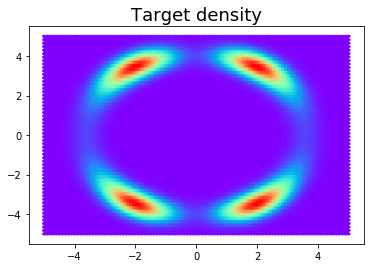

In [13]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1-2) / 0.8) **2)
    exp2 = torch.exp(-0.5 * ((z1+2) / 0.8) **2)
    u = 0.5 * ((norm-4)/ 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# plot 
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:, 0], z[:, 1], C=density_ring(torch.Tensor(z)).numpy().squeeze(),
          cmap='rainbow')
plt.title('Target density', fontsize=18)
plt.show()

In [14]:
class NormalizingFlow(nn.Module):
    def __init__(self, dim, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            biject.append(PlanarFlow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density 
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []
        
    def forward(self, z):
        # applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
    
# create normalizing flow
flow = NormalizingFlow(dim=2, flow_length=16, density=distrib.MultivariateNormal(
    torch.zeros(2), torch.eye(2)))
            

In [15]:
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk)+1e-9)).mean()

In [16]:
import torch.optim as optim

optimizer = optim.Adam(flow.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

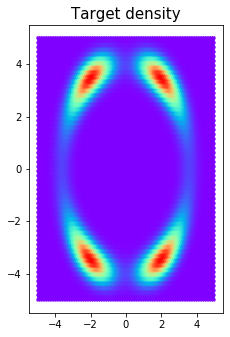

In [20]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
# Main optimization loop
for i in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (i. %i) : %f'%(i, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(i), fontsize=15);
        id_figure += 1
    